# Projected density of states (PDOS)
For the source code, see [pdos](https://workgraph-collections.readthedocs.io/en/latest/ase/espresso/module.html#workgraph_collections.ase.espresso.pdos.pdos_workgraph).


## Visualizing the WorkGraph Builder



In [1]:
from workgraph_collections.ase.espresso.pdos import pdos_workgraph
from aiida import load_profile
load_profile()

task = pdos_workgraph._TaskCls()
task.to_html()

## Visualizing the WorkGraph

In [2]:
from workgraph_collections.ase.espresso.pdos import pdos_workgraph

wg = pdos_workgraph(run_relax=True, run_scf=True)
wg.to_html()

## Example: Silicon

### Prepare the inputs and submit the workflow


In [3]:
from ase.build import bulk
from aiida import load_profile
from copy import deepcopy

from workgraph_collections.ase.espresso.pdos import pdos_workgraph
from aiida_pythonjob.config import config

config["allow_pickle"] = True

load_profile()

atoms = bulk('Al')


metadata = {
    "options": {
        'prepend_text' : """eval "$(conda shell.posix hook)"
        conda activate aiida
        export OMP_NUM_THREADS=1
        """,
    }
}
pseudopotentials = {"Al": "Al.pbe-n-rrkjus_psl.1.0.0.UPF"}
pseudo_dir = "/home/xing/data/ase/espresso_pseudo"
# pseudo_dir = "/home/wang_x3/datas/pseudos/psl"
scf_input_data = {
    "system": {"ecutwfc": 30, "ecutrho": 240,
               "occupations": "smearing",
                "degauss": 0.01,
                "smearing": "gaussian",
                },
}
nscf_input_data = deepcopy(scf_input_data)
nscf_input_data["system"].update({"occupations": "tetrahedra"})
inputs = {
    "scf": {
        "input_data": scf_input_data,
        "kpts": [15, 15, 15],
        "computer": "localhost",
        "metadata": metadata
    },
    "nscf": {
        "input_data": nscf_input_data,
        "kpts": [30, 30, 30],
        "computer": "localhost",
        "metadata": metadata
    },
    "dos": {
        "input_data": {},
        "computer": "localhost",
        "metadata": metadata
    }
}
#------------------------- Set the inputs -------------------------
wg = pdos_workgraph(atoms=atoms,
                    pw_command="mpirun -np 4 pw.x",
                    dos_command="mpirun -np 4 dos.x",
                    projwfc_command="mpirun -np 4 projwfc.x",
                    pseudopotentials=pseudopotentials,
                    pseudo_dir=pseudo_dir,
                    inputs=inputs)
#------------------------- Submit the calculation -------------------
wg.run()
# wg.submit(wait=True, timeout=200)



03/28/2025 08:45:07 AM <1764244> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [63644|WorkGraphEngine|continue_workgraph]: tasks ready to run: pw_calculator1
REPORT:aiida.orm.nodes.process.workflow.workchain.WorkChainNode:[63644|WorkGraphEngine|continue_workgraph]: tasks ready to run: pw_calculator1
03/28/2025 08:45:07 AM <1764244> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [63644|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 63649
REPORT:aiida.orm.nodes.process.workflow.workchain.WorkChainNode:[63644|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 63649
03/28/2025 08:45:12 AM <1764244> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [63644|WorkGraphEngine|update_task_state]: Task: pw_calculator1, type: PythonJob, finished.
REPORT:aiida.orm.nodes.process.workflow.workchain.WorkChainNode:[63644|WorkGraphEngine|update_task_state]: Task: pw_calculator1, type: PythonJob, finished

## Print the results

{'arrays': [[0.0, 3.459e-06, 2.767e-05, 9.338e-05, 0.0003134, 0.0004912, 0.0006978, 0.0009352, 0.001205, 0.001516, 0.001867, 0.002238, 0.002599, 0.002962, 0.003344, 0.003744, 0.004166, 0.004611, 0.005078, 0.005568, 0.006075, 0.006588, 0.007111, 0.007644, 0.008184, 0.008731, 0.009283, 0.009845, 0.01042, 0.01102, 0.01163, 0.01225, 0.0129, 0.01356, 0.01423, 0.01491, 0.01559, 0.01627, 0.01696, 0.01767, 0.01838, 0.0191, 0.01982, 0.02056, 0.0213, 0.02205, 0.02281, 0.02359, 0.02437, 0.02517, 0.02599, 0.02681, 0.02765, 0.02849, 0.02934, 0.03019, 0.03104, 0.0319, 0.03276, 0.03364, 0.03451, 0.0354, 0.0363, 0.0372, 0.03811, 0.03903, 0.03995, 0.04089, 0.04183, 0.04278, 0.04374, 0.04471, 0.04569, 0.04668, 0.04768, 0.04869, 0.0497, 0.05071, 0.05173, 0.05276, 0.05378, 0.05482, 0.05586, 0.0569, 0.05794, 0.059, 0.06006, 0.06113, 0.0622, 0.06329, 0.06438, 0.06547, 0.06658, 0.06769, 0.06881, 0.06994, 0.07107, 0.07221, 0.07336, 0.07452, 0.07569, 0.07685, 0.07803, 0.07921, 0.08039, 0.08158, 0.08277, 0.0839

KeyError: 'atom'

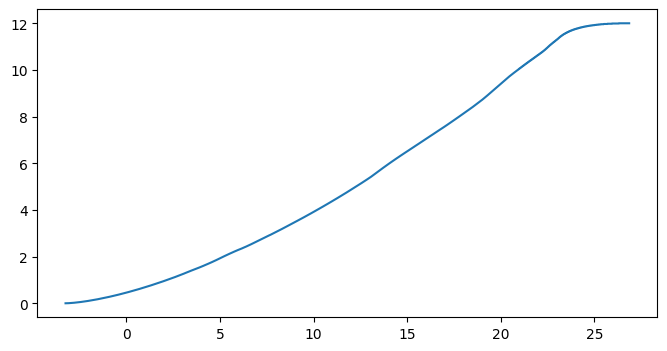

In [27]:
import matplotlib.pyplot as plt
import numpy as np

#------------------------- Print the output -------------------------
dos_data = wg.tasks[-2].outputs.dos.value.value
pdos_data = wg.tasks[-1].outputs.dos.value.value
# make plots
plt.figure(figsize = (8, 4))
plt.plot(dos_data['x']['array'], dos_data['y']['arrays'][0], label='total')
# plt.plot(pdos_data['totol']['energy'], pdos_data['totol']['dos'], label='total')
for file_name, data in pdos_data['atom'].items():
        value = np.array(data)
        plt.plot(value[:, 0], np.sum(value[:, 2:], axis=1), label=file_name[-4:])
plt.yticks([])
plt.xlabel('Energy (eV)')
plt.ylabel('DOS')
plt.legend(frameon=False)


In [35]:
wg.tasks[-1].outputs.projections.value.value

ProjectionData(orbitals=[<RealhydrogenOrbital: r0 S orbital for kind 'Al' @ 0.0000,0.0000,0.0000>, <RealhydrogenOrbital: r0 PZ orbital for kind 'Al' @ 0.0000,0.0000,0.0000>, <RealhydrogenOrbital: r0 PX orbital for kind 'Al' @ 0.0000,0.0000,0.0000>, <RealhydrogenOrbital: r0 PY orbital for kind 'Al' @ 0.0000,0.0000,0.0000>], list_of_projections=[array([[1.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.961, 0.01 , 0.   , 0.   , 0.   , 0.   ],
       [0.864, 0.059, 0.   , 0.   , 0.   , 0.   ],
       ...,
       [0.111, 0.   , 0.007, 0.865, 0.   , 0.   ],
       [0.   , 0.087, 0.   , 0.898, 0.   , 0.   ],
       [0.   , 0.   , 0.099, 0.886, 0.   , 0.002]]), array([[0.   , 0.   , 0.   , 0.   , 0.309, 0.309],
       [0.013, 0.081, 0.038, 0.038, 0.271, 0.271],
       [0.045, 0.125, 0.094, 0.094, 0.217, 0.217],
       ...,
       [0.292, 0.326, 0.307, 0.039, 0.006, 0.02 ],
       [0.327, 0.299, 0.31 , 0.029, 0.013, 0.004],
       [0.329, 0.327, 0.278, 0.032, 0.006, 0.02 ]]), array([[0.   ,